In [1]:
# import libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [29]:
# Load data using pandas.read_csv()

train_data = pd.read_csv('train.csv')

# View partial data

train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# View data dimensions

train_data.shape

(42000, 785)

In [31]:
# Extract the label column and convert it to numpy array

labels = train_data.pop('label').to_numpy()
labels

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [32]:
# Looking at the data dimensions again, the label column has been extracted

train_data.shape

(42000, 784)

In [33]:
train_data = train_data.to_numpy().reshape(-1,28,28)

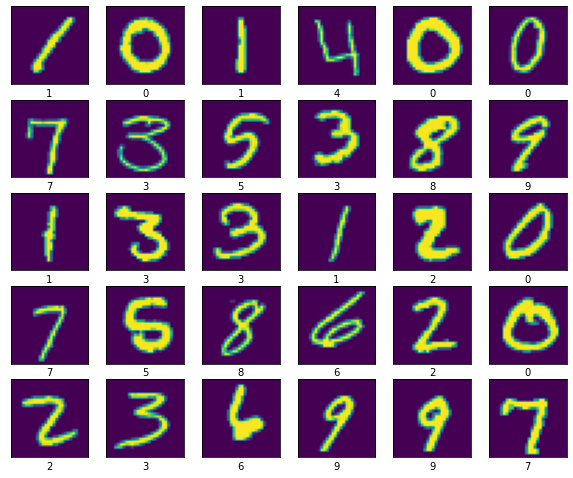

In [34]:
plt.figure(figsize=(10,10))

for i in range(30):
    plt.subplot(6,6,i+1)
    plt.imshow(train_data[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[i])


In [35]:
# Add dimension

train_data = np.expand_dims(train_data,axis=-1)
labels = np.expand_dims(labels,axis=-1)

In [36]:
# You can see that there's one more dimension at the end

train_data.shape

(42000, 28, 28, 1)

In [37]:
labels.shape

(42000, 1)

In [38]:
#Fill the image with zeros around it

train_data = tf.pad(train_data,[[0,0],[2,2],[2,2],[0,0]])

In [39]:
train_data.shape

TensorShape([42000, 32, 32, 1])

In [40]:
num = train_data.shape[0] // 10
train_data, val_data, test_data = tf.split(train_data,[num*8,num,num])
train_label, val_label, test_label = tf.split(labels,[num*8, num, num])

In [41]:
print('train:',train_data.shape,'-- label:',train_label.shape)
print('validition:',val_data.shape,'-- label:',val_label.shape)
print('test:',test_data.shape,'-- label:',test_label.shape)

train: (33600, 32, 32, 1) -- label: (33600, 1)
validition: (4200, 32, 32, 1) -- label: (4200, 1)
test: (4200, 32, 32, 1) -- label: (4200, 1)


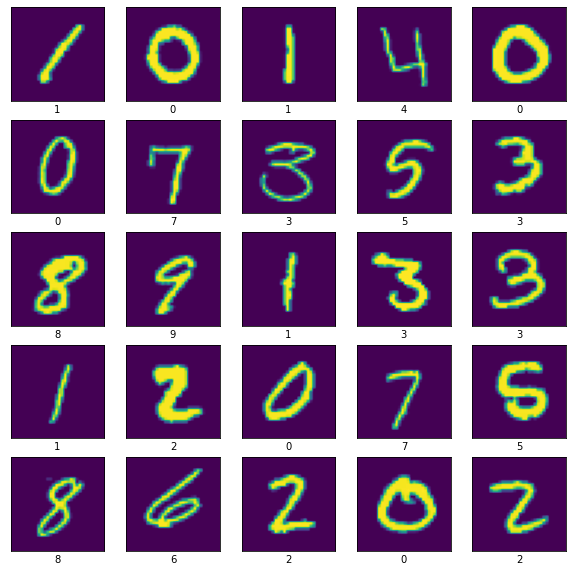

In [42]:
# Show some pictures. Everything is all right
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_data[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train_label[i][0].numpy())

In [43]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data,train_label)).shuffle(33600,seed=42).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((val_data,val_label)).shuffle(33600,seed=42).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((test_data,test_label)).shuffle(33600,seed=42).batch(128)

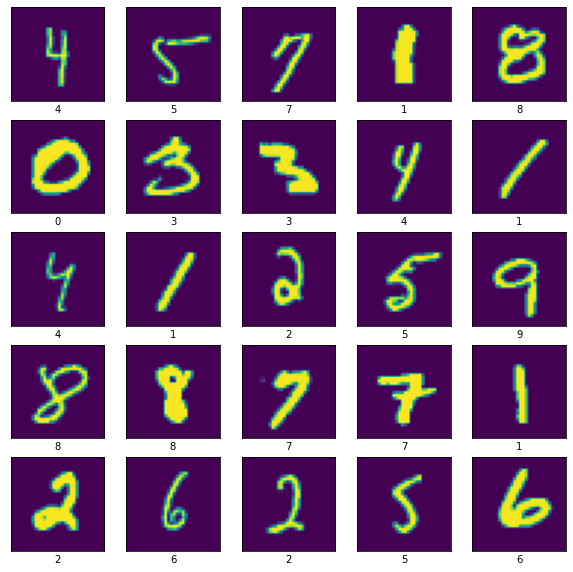

In [44]:
# Use 'take' to view a batch of data

plt.figure(figsize=(10,10))

for image,label in train_ds.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image[i])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(label[i][0].numpy())

In [45]:
# The shape of the picture

image_shape = (32,32,1)

In [50]:
class MCDropout(layers.Dropout):
    def call(self,inputs):
        return super().call(inputs,training=True)


# Use a LeNet-style neural network. Some parameters are adjusted

inputs = layers.Input(shape=image_shape)
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs) # normalized
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.MaxPooling2D(2,strides=2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.MaxPooling2D(2,strides=2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128,5,strides=1,activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(84,activation='relu')(x)
x = MCDropout(0.1)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs,outputs)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [51]:
#View network architecture
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 128)       409728    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 128)         0   

In [71]:
# Using EarlyStopping, end training when val_accuracy is not improved for 10 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                    patience=10,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 5 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5,patience=5)

with tf.device("/gpu:0"):
    history = model.fit(train_ds,batch_size=128,epochs=10,validation_data=val_ds,
                        callbacks=[early_stopping,lr_scheduler])

Epoch 1/10
263/263 [==============================] - 9s 34ms/step - loss: 3.8263e-04 - accuracy: 0.9999 - val_loss: 0.0755 - val_accuracy: 0.9929
Epoch 2/10
263/263 [==============================] - 9s 34ms/step - loss: 2.1712e-04 - accuracy: 0.9999 - val_loss: 0.0732 - val_accuracy: 0.9931
Epoch 3/10
263/263 [==============================] - 9s 34ms/step - loss: 2.3611e-04 - accuracy: 0.9999 - val_loss: 0.0777 - val_accuracy: 0.9924- loss: 1.920 - ETA: 
Epoch 4/10
263/263 [==============================] - 9s 34ms/step - loss: 6.2489e-05 - accuracy: 1.0000 - val_loss: 0.0814 - val_accuracy: 0.9926
Epoch 5/10
263/263 [==============================] - 9s 35ms/step - loss: 1.6081e-04 - accuracy: 1.0000 - val_loss: 0.0790 - val_accuracy: 0.9919
Epoch 6/10
263/263 [==============================] - 9s 34ms/step - loss: 5.8927e-05 - accuracy: 1.0000 - val_loss: 0.0728 - val_accuracy: 0.9924
Epoch 7/10
263/263 [==============================] - 9s 34ms/step - loss: 8.6378e-05 - accuracy:

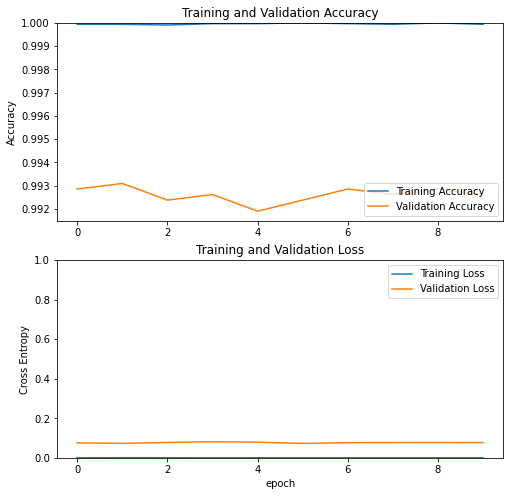

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [73]:
# test model
model.evaluate(test_ds,verbose=2)

33/33 - 0s - loss: 0.0366 - accuracy: 0.9938


[0.03664783015847206, 0.9938095211982727]

In [74]:
# load data

test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [75]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [77]:
# process data

test = test.to_numpy().reshape(-1,28,28)
test = np.expand_dims(test,axis=-1)
test = tf.pad(test,[[0,0],[2,2],[2,2],[0,0]])

test.shape

TensorShape([28000, 32, 32, 1])

In [78]:
sample_submission.shape

(28000, 2)

In [79]:
# predict
result =  model.predict(test)

result.shape

(28000, 10)

In [80]:
# get predict label
predict_label = np.argmax(result,axis=-1)

predict_label.shape

(28000,)

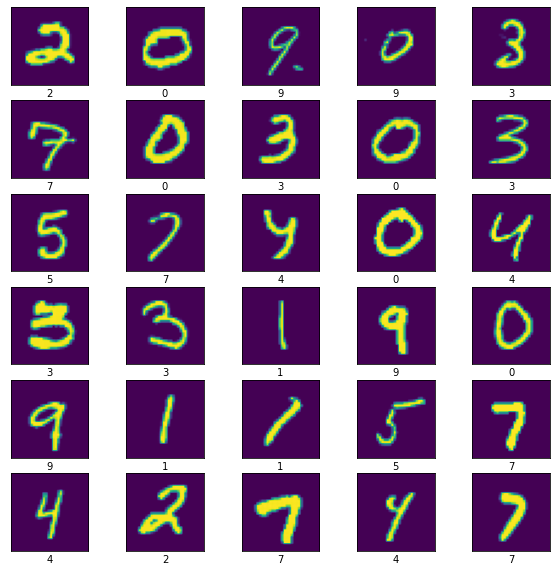

In [81]:
# Show some prediction results

plt.figure(figsize=(10,10))

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(test[i,...,0])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(predict_label[i])

In [68]:
sample_submission['Label'] = predict_label

In [69]:
sample_submission.to_csv('submission.csv', index=False)

In [70]:
sample_submission.shape

(28000, 2)